# Problem Set 1

For this problem set we will look at patterns of genetic diversity at the _LCT_ and _MCM6_ genes. Studies have shown that this locus exhibits signals consistent with positive selection in European populations and is associated with lactase persistence—a trait unique among mammals and is thought to be a result of cattle domestication and the incorporation of milk into the adult diets of several human populations (Enattah et al. 2002; Marnetto and Huerta-Sánchez 2017; Smith et al. 2018).

__ASSIGNMENT__
- There are five coding problems, one interpretation problem, and one extra credit coding problem.
- The following python modules are required to complete this problem set, however, you can use other modules at your own risk.
- Do not alter the code in the `Data Processing` section except for changing file paths.
- You may not work with other students, but you may ask the instructor questions by email or by coming to office hours, reference package documentation, reference coding exercises from previous lectures, and refernce the course GitHub.

__HELPFUL HINTS__
- Feel free to add more cells if needed!
- Don't forget to consider ploidy.
- Remember the bounds for the site frequency spectrum.
- Take a deep breath, and remember that you are very capable!

In [1]:
# Import modules.
import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

## Data Processing 

First, I will load the converted vcf file as a HDF5 file and extract the necessary information needed to complete this problem set.

In [2]:
# Load the hdf5 data.
lct_mcm6_h5 = h5py.File(
    "./data/tgp_lct_mcm6_biallelic_snps_anc_calls_filtered.h5", mode="r"
)
# Extract the genotypes.
lct_mcm6_gt = lct_mcm6_h5["calldata/GT"][:]
# Convert the genotypes to an alternative allele count matrix.
lct_mcm6_aac_mat = np.sum(lct_mcm6_gt, axis=2)
# Extract the variable positions array.
lct_mcm6_pos = lct_mcm6_h5["variants/POS"][:]

#
#(1) The genotypes (a,b) for each of 2504 (+1) individuals at 2464 sites is extracted
#    * the last entry (+1) being the reference sequence
#(2) The genotypes are summed across that last dimension (axis=2) to get single numbers 
#    ex. (1,1) becomes (2)
#(3) Variable positions array ??

Next, I will define a function to polarize the allele count matrix and subsequently convert the alternative allele count matrix to the derived allele count matrix.

In [3]:
# Define a function to convert genotypes to derived allele counts.
def aac_2_dac(aac):
    """Returns a derived allele count matrix where an individual can have
       the following possible genotype entries:

       0 = homozygous for the ancestral allele
       1 = heterozygous
       2 = homozygous for the derived allele

    aac -- alternative allele count matrix with the outgroup encoded in
           the last column of the matrix.
    """
    # Intialize a derived allele count matrix.
    dac = np.empty_like(aac[:, 0:-1])
    # For every site...
    for site in range(aac.shape[0]):
        # Extract the tgp samples and ancestor.
        tgp = aac[site, 0:-1]
        anc = aac[site, -1]
        # If the alternative allele is the derived allele...
        if anc > 0:
            # Polarize the tgp.
            p_tgp = np.abs(tgp - 2)
            # Fill the derived allele count matrix.
            dac[site, :] = p_tgp
        # Else...
        else:
            # Fill the derived allele count matrix.
            dac[site, :] = tgp
    return dac

#
#(1) An aac (like the one above) is input
#(2) A placeholder dac matrix is initialized with all 0 and (-1) less row (excludes ancestor reference)
#(3) For EACH site in aac.shape[0] (2464 sites), we get
#    * tgp (all other individuals' genotypes)
#    * anc (JUST the last row, the reference)
#    (a) IF the ancestral genotype is anything other than (0,0), so (1,0)/(0,1) or (1,1)
#    then we take our tgp's and -2, then ABS.
#        ** This essentially makes any genotypes=2 into 0 (b/c they are NOT derived given they match the ancestor)
#        ** This also makes any genotypes=1 into 1, b/c they only half match the ancestor
#        (i) Once polarized, we can assign dac[site,:] to the new tgp array
#    (b) ELSE if the ancestral genotype WAS (0,0), then
#        (i) our tgp is accurate already, so we just assign dac[site,:] to the tgp array
#(4) Return the dac_mat


In [4]:
# Convert the alternative allele count matrix to
# the derived allele count matrix.
lct_mcm6_dac_mat = aac_2_dac(lct_mcm6_aac_mat)

As, a sanity check let's make sure there are the same number of sites in the positions array as in the derived allele count matrix. Note: If the size of the positions array and the size of the first dimension in the derived allele count matrix is not 2464 contact the instructor ASAP.

In [5]:
# Show the size of posistions array.
lct_mcm6_pos.size

2464

In [6]:
# Show the shape of the derived allele count matrix.
lct_mcm6_dac_mat.shape

(2464, 2504)

Great, the positions array and the derived allele count matrix are in agreement. Throughout this problem set you will run analyses on each super-population from the 1000 Genome's Project (TGP), so the last thing I will do for you is subset the original derived allele count matrix by super-population—however feel free to work from the original derived allele count matrix if you wish!

In [7]:
# Load the tgp metadata as a pandas dataframe.
meta_df = pd.read_csv(
    "./data/tgp_meta_data.txt",
    sep="\t",
    names=["Individual", "Population", "Super-Population"],
)
# Intialize a super population list.
superpop_list = ["AFR", "SAS", "EAS", "EUR", "AMR"]
# Intialize a dictionary to store indicies.
superpop_idx_dicc = {}
# For every super population...
for superpop in superpop_list:
    # Fill the dictionary.
    superpop_idx_dicc[superpop] = meta_df[
        meta_df["Super-Population"] == superpop
    ].index.values
# Extract the derived allele count matrix for each super population.
afr_dac_mat = lct_mcm6_dac_mat[:, superpop_idx_dicc["AFR"]]
sas_dac_mat = lct_mcm6_dac_mat[:, superpop_idx_dicc["SAS"]]
eas_dac_mat = lct_mcm6_dac_mat[:, superpop_idx_dicc["EAS"]]
eur_dac_mat = lct_mcm6_dac_mat[:, superpop_idx_dicc["EUR"]]
amr_dac_mat = lct_mcm6_dac_mat[:, superpop_idx_dicc["AMR"]]

#
#(1) Read the meta-data file that contains each individual and their superpop
#(2) Initialize a list of superpops we are interested in
#(3) Initialize a dictionary
#(4) For each superpop in our list, 
#    (a) find values where the "Super-Population" column in the metadata
#        is equal to that superpop. 
#    (b) find the list of indeces (.index.values) for those entries
#    (c) add it to the dictionary labeled as that superpop.
#(5) Extract a separate dac_mat for ALL sites and the indxs for each superpop [:, dictionary["superpop"]]


## Segregating Sites ($S$)

In the `Data Processing` section we determined how many segrgating sites were observed among all individuals in the TGP.

__(1) Compute the number of segregating sites observed in each super-population.__

In [8]:
def count_seg_site(dac_mat):
    """Returns segregating site count by checking for
    sites with only genotype 0 (0 0) or 2 (1 1) across
    the pop"""

    # Find sum of all genotypes per site (row, axis=1)
    sum_der = np.sum(dac_mat, axis = 1)

    seg_site = 0
    
    for site in sum_der:
        # Checks for sums of 0 (all geno-0) or .shape[1]*2 (individuals*2, all geno-2)
        # Either case is NOT a segregating site. 
        if site != 0 and site != dac_mat.shape[1]*2:
            seg_site += 1

    return seg_site

In [21]:
afr_seg_site = count_seg_site(afr_dac_mat)
sas_seg_site = count_seg_site(sas_dac_mat)
eas_seg_site = count_seg_site(eas_dac_mat)
eur_seg_site = count_seg_site(eur_dac_mat)
amr_seg_site = count_seg_site(amr_dac_mat)

SEGS = [afr_seg_site, sas_seg_site, eas_seg_site, eur_seg_site, amr_seg_site]

In [22]:
print(f"AFR: {afr_seg_site = }")
print(f"SAS: {sas_seg_site = }")
print(f"EAS: {eas_seg_site = }")
print(f"EUR: {eur_seg_site = }")
print(f"AMR: {amr_seg_site = }")

AFR: afr_seg_site = 1193
SAS: sas_seg_site = 732
EAS: eas_seg_site = 722
EUR: eur_seg_site = 546
AMR: amr_seg_site = 772


## Nucleotide Diversity ($\pi$)

__(2) Compute the average nucleotide diversity—do not normalize by the number of sites—for each super-population.__

In [23]:
import math
def nuc_d(dac_mat):
    """Calculate pairwise differences"""
    pw_diff = 0
    
    # Loop over each site
    for i in range(dac_mat.shape[1]):
        # Loop over each 'other' site
        for j in range(i+1, dac_mat.shape[1]):
            # if i != j, then adds to count, for all individuals
            pw_diff += np.count_nonzero((dac_mat[:,i] != dac_mat[:,j]))

    denom = math.comb(dac_mat.shape[1], 2)
    pi = pw_diff/denom
    return pi

In [24]:
regions = ['AFR', 'SAS', 'EAS', 'EUR', 'AMR']
MATS = [afr_dac_mat, sas_dac_mat, eas_dac_mat, eur_dac_mat, amr_dac_mat]

PIS = []
for i in MATS: 
    PIS.append(nuc_d(i))

for i in range(len(PIS)):
    print(f"{regions[i]}: {regions[i].lower()+'_pi ='} {PIS[i]}")

AFR: afr_pi = 128.8993994407005
SAS: sas_pi = 86.60023802340005
EAS: eas_pi = 101.43701284357348
EUR: eur_pi = 76.61852787656531
AMR: amr_pi = 90.7628558578068


## Derived Allele Frequency Spectrum (aka Unfolded SFS)

__(3) Compute the derived allele frequency spectrum for each super-population.__

In [40]:
def unfolded_sfs(dac_mat):
    freqs = np.sum(dac_mat, axis=1)
    sfs = np.bincount(freqs, minlength=dac_mat.shape[1]*2)[1:-1]
    return sfs

(array([1.318e+03, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0. ,  44.2,  88.4, 132.6, 176.8, 221. , 265.2, 309.4, 353.6,
        397.8, 442. ]),
 <BarContainer object of 10 artists>)

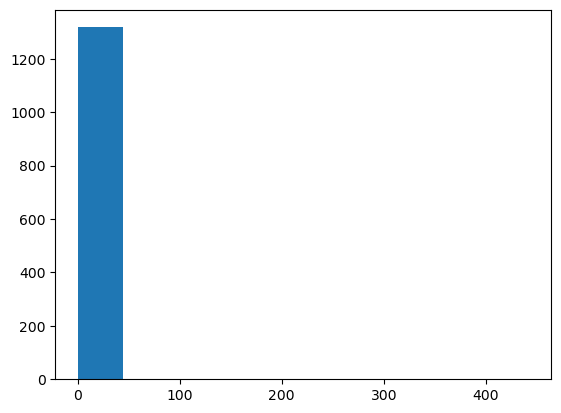

In [44]:
plt.hist(unfolded_sfs(afr_dac_mat))

## Interpretation

__(4) Generate a table displaying the number of segregating sites and average nucleotide diversity for each super-population__

In [27]:
df = pd.DataFrame()
df['PI'] = PIS
df['SEG'] = SEGS

In [28]:
display(df)

,PI,SEG
0,128.899399,1193
1,86.600238,732
2,101.437013,722
3,76.618528,546
4,90.762856,772


__(5) Plot the derived allele frequency spectrum for a population (other than KHV). Plot the derived allele frequency spectrum for two super-populations__

For example, if we wanted to plot the derived allele frequency spectrum for the KHV (Kinh in Ho Chi Minh City) population, we would first subset the original data to only include the KHV individuals (take a look at the middle column in `data/tgp_meta_data.txt` to find other population codes) and find the SFS for these individuals:

In [29]:
# Extract the population indicies.
khv_indices = meta_df[meta_df["Population"] == "KHV"].index.values
# Subset the genotype matrix.
khv_dac_mat = lct_mcm6_dac_mat[:, khv_indices]
# Determine the derived allele count per site.
khv_per_site_dac = np.sum(khv_dac_mat, axis=1)
# Determine the number of chromosomes.
khv_chroms = khv_dac_mat.shape[1] * 2
# Bin the derived allele count and extract the unfolded sfs.
khv_sfs = np.bincount(khv_per_site_dac, minlength=khv_chroms)[1:-1]

(array([191.,   1.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0. ,  11.3,  22.6,  33.9,  45.2,  56.5,  67.8,  79.1,  90.4,
        101.7, 113. ]),
 <BarContainer object of 10 artists>)

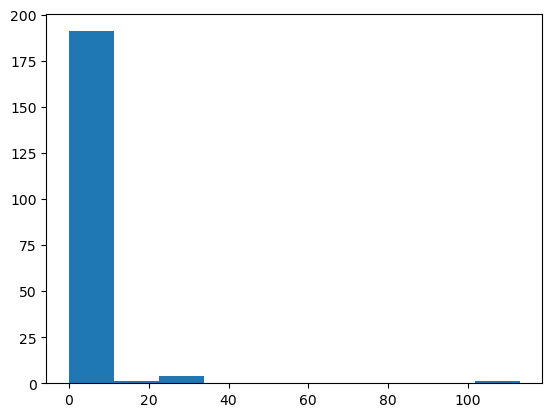

In [31]:
plt.hist(khv_sfs)

Now we can plot the derived allele frequency spectrum by creating a plotting canvas using the `matplotlib` library

In [ ]:
# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the SFS.
ax.bar(
    np.arange(1, khv_chroms), # X axis: [1, (n-1)/n]
    khv_sfs, # Y axis    
)
# Set the x-axis tick positions and labels.
xtick_positions = np.unique(
    np.concatenate([
        [1],  # Always include the first bin
        np.arange(10, khv_chroms - 1, 10),  # Label every 10^th bin.
        [khv_chroms - 1]  # Always include the last bin
    ])
)
ax.set_xticks(xtick_positions)
ax.set_xticklabels(
    xtick_positions.astype(str),
    rotation=45, ha='right',
    rotation_mode='anchor',
)
ax.set_xticks(xtick_positions)
# Label the axes and set the title.
ax.set_xlabel('Derived Allele Count')
ax.set_ylabel('Number of Segregating Sites')
ax.set_title('Site Frequency Spectrum (KHV)', fontweight='bold')
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Show!
plt.show()

__(6) Interpret your plots from question (5)__ (Hint: Reflect on our conversations about the assigned reading: 1000 Genomes Project Consortium. "A global reference for human genetic variation." _Nature_ 526.7571 (2015): 68.)

## EXTRA CREDIT: Gene Diversity ($H$)

__(E1) Compute the average gene diversity for each super-population.__